In [2]:
from functools import reduce
from itertools import islice
import math
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# from hyperspherical_vae.distributions import VonMisesFisher, HypersphericalUniform

%matplotlib inline

/Users/bbevers/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pyspark
sc = pyspark.SparkContext('local[*]')
spark = pyspark.sql.SparkSession(sc)

In [4]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.15

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

# rv5 = generate_cluster(unit, (on, -off, off), [0,0,2], 1250000)
# rv6 = generate_cluster(unit, (-on, off, -off), [0,2,0], 1000000)
# 
# data = np.append(shuffle(rv1, rv2, rv3, rv4), shuffle(rv5, rv6), axis=1)

data = reduce(lambda a,b: np.append(a, b, axis=0), [rv1, rv2, rv3, rv4])

# ind_var = np.random.uniform(-1, 1, [data.shape[0], 20])

# data = np.append(data, ind_var, axis=1)

data = shuffle(data)

# data = reduce_correlation(data, [0.75, 0.75, 0.75])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.86533005, -2.73414875, -2.60296746, -2.47178617, -2.34060487,
        -2.20942358, -2.07824229, -1.94706099, -1.8158797 , -1.68469841,
        -1.55351711, -1.42233582, -1.29115452, -1.15997323, -1.02879194,
        -0.89761064, -0.76642935, -0.63524806, -0.50406676, -0.37288547,
        -0.24170418, -0.11052288,  0.02065841,  0.15183971,  0.283021  ,
         0.41420229,  0.54538359,  0.67656488,  0.80774617,  0.93892747,
         1.07010876,  1.20129005,  1.33247135,  1.46365264,  1.59483394,
         1.72601523,  1.85719652,  1.98837782,  2.11955911,  2.2507404 ,
         2.3819217 ,  2.51310299,  2.64428428,  2.77546558,  2.90664687,
         3.03782817,  3.16900946,  3.30019075,  3.43137205,  3.56255334,
         3.69373463])

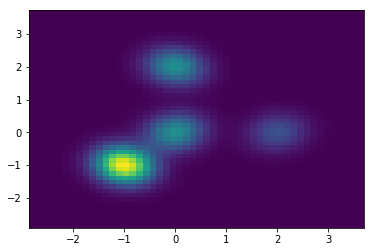

In [5]:
plt.hist2d(data[:,0], data[:,1], bins=50)

In [6]:
class VariationalAutoEncoder(object):
    def __init__(self, n_input_units, n_hidden_layers, n_hidden_units, n_latent_units,
                 learning_rate=0.005, batch_size=100, min_beta=1.0, max_beta=1.0,
                 distribution='normal'):
        self.n_input_units = n_input_units
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.distribution = distribution

    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units, distribution):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            self.distribution = distribution

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_mu(self, inputs):
            if self.distribution == 'normal':
                self.mu = tf.layers.Dense(units=self.n_latent_units)
            elif self.distribution == 'vmf':
                self.mu = tf.layers.Dense(units=self.n_latent_units + 1, 
                                          activation=lambda x: tf.nn.l2_normalize(x, axis=-1))
            else:
                raise NotImplemented
                
            self.applied_mu = self.mu.apply(inputs)
            return self.applied_mu

        def add_sigma(self, inputs):
            if self.distribution == 'normal':
                self.sigma = tf.layers.Dense(units=self.n_latent_units)
                self.applied_sigma = self.sigma.apply(inputs)
            elif self.distribution == 'vmf':
                self.sigma = tf.layers.Dense(units=1, activation=tf.nn.softplus)
                self.applied_sigma = self.sigma.apply(inputs) + 1
            else:
                raise NotImplemented
            return self.applied_sigma

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            mu = self.add_mu(layer)
            sigma = self.add_sigma(layer)

            return mu, sigma

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            mu = sess.run([self.mu.kernel, self.mu.bias])

            sigma = sess.run([self.sigma.kernel, self.sigma.bias])

            return layers, mu, sigma

    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []

        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_output(self, inputs):
            self.output = tf.layers.Dense(units=self.n_output_units)
            self.applied_output = self.output.apply(inputs)
            return self.applied_output

        def build(self, inputs):
            self.init_hidden_layers()

            layer = self.add_hidden_layer(inputs)

            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)

            output = self.add_output(layer)

            return output

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            output = sess.run([self.output.kernel, self.output.bias])

            return layers, output

    def sampled_z(self, mu, sigma, batch_size):
        if self.distribution == 'normal':
            epsilon = tf.random_normal(tf.stack([int(batch_size), self.n_latent_units]))
            z = mu + tf.multiply(epsilon, tf.exp(0.5 * sigma))
            loss = tf.reduce_mean(-0.5 * self.beta * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), 1))
        elif self.distribution == 'vmf':
            self.q_z = VonMisesFisher(mu, sigma, validate_args=True, allow_nan_stats=False)
            z = self.q_z.sample()
            self.p_z = HypersphericalUniform(self.n_latent_units, validate_args=True, allow_nan_stats=False)
            loss = tf.reduce_mean(-self.q_z.kl_divergence(self.p_z))
        else:
            raise NotImplemented

        return z, loss

    def build_feature_loss(self, x, output):
        return tf.reduce_mean(tf.reduce_sum(tf.squared_difference(x, output), 1))

    def initialize_tensors(self):
        self.x = tf.placeholder("float32", [self.batch_size, self.n_input_units])
        self.beta = tf.placeholder("float32", [1, 1])
        self.encoder = self.Encoder(self.n_hidden_layers, self.n_hidden_units, self.n_latent_units, 
                                    self.distribution)
        mu, sigma = self.encoder.build(self.x)
        self.mu = mu
        self.sigma = sigma
        
        z, latent_loss = self.sampled_z(self.mu, self.sigma, self.batch_size)
        self.z = z
        self.latent_loss = latent_loss
        
        self.decoder = self.Decoder(self.n_hidden_layers, self.n_hidden_units, self.n_input_units)
        self.output = self.decoder.build(self.z)
        
        self.feature_loss = self.build_feature_loss(self.x, self.output)
        self.loss = self.feature_loss + self.latent_loss
        

    def generate_beta_values(self, data_count, epochs):
        num_batches = int(data_count / self.batch_size)
        total_steps = (num_batches * epochs) - epochs
        beta_delta = self.max_beta - self.min_beta
        log_beta_step = 5 / float(total_steps)
        beta_values = [
            self.min_beta + (beta_delta * (1 - math.exp(-5 + (i * log_beta_step))))
            for i in range(total_steps)
        ]
        return beta_values

    def train_from_rdd(self, data_rdd, epochs=1):
        self.initialize_tensors()

        data_count = data_rdd.count()
        beta_values = self.generate_beta_values(data_count, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_index in range(epochs):
                iterator = data_rdd.toLocalIterator()
                batch_index = 0
                while True:
                    batch = np.array(list(islice(iterator, self.batch_size)))
                    if batch.shape[0] == self.batch_size:
                        beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                        feed_dict = {self.x: np.array(batch), self.beta: np.array([[beta]])}

                        if not batch_index % 1000:
                            print("beta: {}".format(beta))
                            ls, f_ls, d_ls = sess.run([self.loss, self.feature_loss, self.latent_loss],
                                                      feed_dict=feed_dict)
                            print("loss={}, avg_feature_loss={}, avg_latent_loss={}".format(ls, np.mean(f_ls),
                                                                                            np.mean(d_ls)))
                            print('running batch {} in epoch {}'.format(batch_index, epoch_index))
                        sess.run(optimizer, feed_dict=feed_dict)
                        batch_index += 1
                    else:
                        print("incomplete batch: {}".format(batch.shape))
                        break

            print("evaluating model...")
            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)

    def train(self, data, visualize=False, epochs=1):
        self.initialize_tensors()
        
        data_size = data.shape[0]
        batch_size = self.batch_size
        beta_values = self.generate_beta_values(data_size, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            i = 0
            while (i * batch_size) < data_size:
                batch = data[i * batch_size:(i + 1) * batch_size]
                beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                feed_dict = {self.x: batch, self.beta: np.array([[beta]])}
                sess.run(optimizer, feed_dict=feed_dict)
                if visualize and (not i % int((data_size / batch_size) / 3) or i == int(data_size / batch_size) - 1):
                    ls, d, f_ls, d_ls = sess.run([self.loss, self.output, self.feature_loss, self.latent_loss],
                                                 feed_dict=feed_dict)
                    plt.scatter(batch[:, 0], batch[:, 1])
                    plt.show()
                    plt.scatter(d[:, 0], d[:, 1])
                    plt.show()
                    print(i, ls, np.mean(f_ls), np.mean(d_ls))

                i += 1

            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)


class VariationalAutoEncoderModel(object):
    def __init__(self, encoder_layers, mu, sigma, decoder_layers, output):
        self.encoder = self.EncoderModel(encoder_layers, mu, sigma)
        self.decoder = self.DecoderModel(decoder_layers, output)

    def save(self, path):
        encoder_layers, encoder_mu, encoder_sigma = self.encoder.dump()
        decoder_layers, decoder_output = self.decoder.dump()
        serializable_model = (encoder_layers, encoder_mu, encoder_sigma, decoder_layers, decoder_output)
        pickle.dump(serializable_model, open(path, 'w+'))

    def encode(self, x):
        return self.encoder.encode(x)

    def project(self, x):
        return self.encoder.encode(x)[0]

    def decode(self, x):
        return self.decoder.decode(x)

    @classmethod
    def load(cls, path):
        return cls(*pickle.load(open(path, 'r')))

    class Layer(object):
        def __init__(self, kernel, bias, activation='linear'):
            self.kernel = kernel
            self.bias = bias
            self.activation = activation

        def dump(self):
            return (self.kernel, self.bias, self.activation)

        @property
        def apply_func(self):
            kernel, bias = self.kernel, self.bias

            linear = lambda inputs: np.matmul(inputs, kernel) + bias

            if self.activation == 'linear':
                f = linear
            elif self.activation == 'sigmoid':
                f = lambda inputs: 1 / (1 + np.exp(-linear(inputs)))

            return f

        def apply(self, inputs):
            return self.apply_func(inputs)

    class EncoderModel(object):
        def __init__(self, encoder_layers, mu, sigma):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in encoder_layers
            ]
            self.mu = VariationalAutoEncoderModel.Layer(*mu)
            self.sigma = VariationalAutoEncoderModel.Layer(*sigma)

        def dump(self):
            encoder_layers = [l.dump()[:2] for l in self.layers]
            encoder_mu = self.mu.dump()[:2]
            encoder_sigma = self.sigma.dump()[:2]
            return encoder_layers, encoder_mu, encoder_sigma

        def encode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.mu.apply(x), self.sigma.apply(x)

    class DecoderModel(object):
        def __init__(self, decoder_layers, output):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in decoder_layers
            ]
            self.output = VariationalAutoEncoderModel.Layer(*output)

        def dump(self):
            decoder_layers = [l.dump()[:2] for l in self.layers]
            decoder_output = self.output.dump()[:2]
            return decoder_layers, decoder_output

        def decode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.output.apply(x)


In [7]:
rdd = sc.parallelize(data)

model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=2, 
                               n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.005, batch_size=1000, 
                               min_beta=0.01, max_beta=1, distribution='normal')\
    .train_from_rdd(rdd, epochs=1)

beta: 0.993329432471
loss=4.47393751144, avg_feature_loss=4.15156364441, avg_latent_loss=0.322373718023
running batch 0 in epoch 0
beta: 0.938384389304
loss=2.28316926956, avg_feature_loss=1.24345874786, avg_latent_loss=1.03971064091
running batch 1000 in epoch 0
beta: 0.430860498018
loss=1.22265672684, avg_feature_loss=0.52480918169, avg_latent_loss=0.697847485542
running batch 2000 in epoch 0
incomplete batch: (0,)
evaluating model...


In [6]:
# model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=2, 
#                                n_hidden_units=9, n_latent_units=1, 
#                                learning_rate=0.005, batch_size=100, 
#                                min_beta=1, max_beta=1, distribution='vmf')\
#     .train(data, epochs=1, visualize=True)

(array([ 68., 248., 335., 357., 391., 415., 359., 391., 384., 343., 324.,
        231., 233., 173., 141., 119.,  93.,  76.,  49.,  40.,  34.,  23.,
         27.,  24.,  20.,  11.,  11.,  20.,  14.,   0.,   7.,   9.,   8.,
         11.,  33., 136., 772., 653., 420., 250., 123.,  52.,  17.,  15.,
         16.,  32.,  58.,  81., 143., 278., 490., 712., 806., 810., 691.,
        443., 246.,  98.,  45.,  10.,   5.,   5.,   2.,   0.,   3.,   2.,
         11.,   2.,   7.,   7.,  15.,   7.,  25.,  43.,  44.,  50.,  66.,
         85., 116., 151., 166., 246., 267., 340., 430., 503., 598., 670.,
        788., 891., 820., 805., 799., 721., 553., 420., 241., 128.,  68.,
         16.]),
 array([-1.68547198, -1.65597804, -1.62648411, -1.59699018, -1.56749624,
        -1.53800231, -1.50850838, -1.47901444, -1.44952051, -1.42002658,
        -1.39053264, -1.36103871, -1.33154477, -1.30205084, -1.27255691,
        -1.24306297, -1.21356904, -1.18407511, -1.15458117, -1.12508724,
        -1.09559331, -1.06

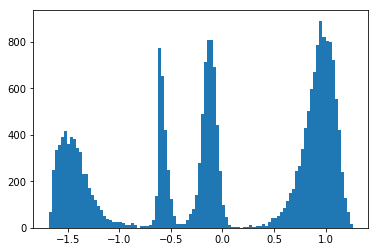

In [9]:
encoded_sample = model.project(data)
plt.hist(encoded_sample, bins=100)

In [8]:
vec_sample = np.array(rdd.sample(False, 0.01).collect())
encoded_sample = model.project(vec_sample)

# decoded_sample = data
decoded_sample = model.decode(encoded_sample)
decoded_sample.shape

(22535, 3)

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

encoded_x_sample = encoded_sample[:,0].reshape(-1,1)
dencoded_y_sample = decoded_sample[:,0].reshape(-1,1)

for i in range(2, 10):
  z_train, z_test, x_train, x_test = train_test_split(encoded_x_sample, dencoded_y_sample, test_size=0.4)
  gmm = GaussianMixture(i).fit(z_train)
  bic = gmm.bic(z_test)
  labels = gmm.predict(z_test)
  ss = silhouette_score(x_test, labels)
  print(i, bic, ss)

(2, 22860.687369517636, 0.41072610349447514)
(3, 12763.132987421812, 0.4873411057035125)
(4, 9621.984985738864, 0.6049687548656997)
(5, 9496.53577122682, 0.5700197372127715)
(6, 9048.603016026918, 0.37332278940894126)
(7, 8913.499825276993, 0.31950360789236504)
(8, 8888.716481612686, 0.2757845583639317)
(9, 8776.807228609861, 0.30912203993217174)


In [31]:
a = np.append(labels.reshape(-1,1), x_test, axis=1)

In [38]:
np.where()

(array([   0,    0,    1, ..., 9012, 9013, 9013]),
 array([0, 1, 0, ..., 1, 0, 1]))